Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 1

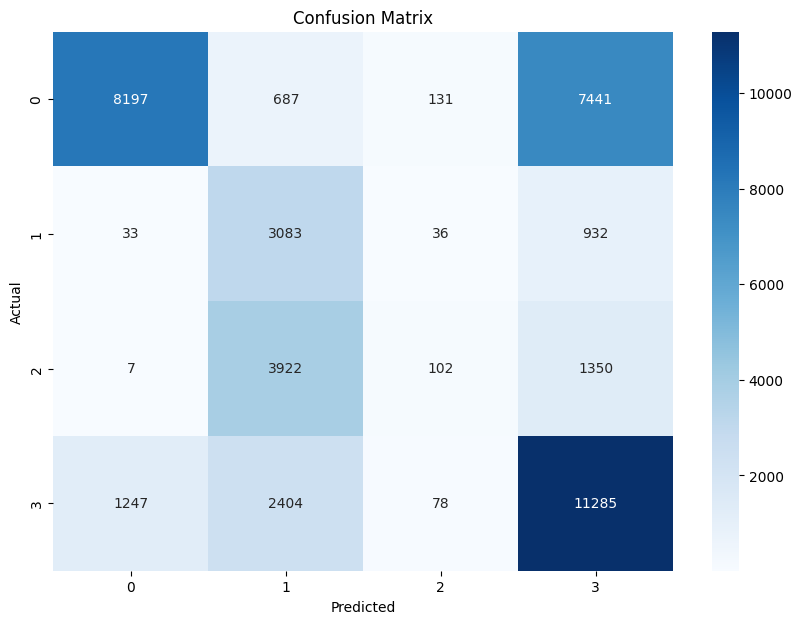

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
df = pd.read_csv("Dataset_timeseries.csv")
df = df.drop(columns=['Time (s)'])
X = df[['SOPAS']].values  # Features
y = df['Number'].values   # Target

# Reshape the input data to 3D for LSTM (samples, timesteps, features)
# Assuming you want to consider a window of past 10 'SOPAS' values to predict the 'Number'
window_size = 10
X_seq = []
y_seq = []
for i in range(len(X) - window_size):
    X_seq.append(X[i:i+window_size])
    y_seq.append(y[i+window_size])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
# Reshape X_train and X_test to 2D for scaling
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)
# Reshape back to 3D
X_train = X_train_scaled.reshape(X_train.shape[0], window_size, -1)
X_test = X_test_scaled.reshape(X_test.shape[0], window_size, -1)

# Define the LSTM model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='softmax')  # 4 output classes (0, 1, 2, 3)
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Example: Class weighting
class_weights = {0: 1.0, 1: 4.0, 2: 3.0, 3: 2.0}  # Higher weight for the minority class
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, class_weight=class_weights)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()
print(f"Accuracy: {accuracy_score(y_test, y_pred_classes)}")
print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
